In [1]:
import scipy.signal
import torch
from src.utils.fourier import dft, idft
import matplotlib.pyplot as plt
import scipy
import numpy as np
# from src.utils.filters import MovingAvg
from src.utils.fourier import sphere2complex, complex2sphere

# def moving_average_freq_response(N, sample_rate, freq):
#     omega = 2 * torch.pi * freq / sample_rate
#     # SMA coefficients
#     b = np.ones(N)
#     a = np.array([N] + [0]*(N-1))

#     # Calculate the frequency response
#     w, h = scipy.signal.freqz(b, a, worN=omega)
#     # w *= sample_rate / (2 * np.pi)                      # Convert from rad/sample to Hz
#     return h

def moving_average_freq_response(N, sample_rate, freq):
    omega = 2 * torch.pi * freq / sample_rate
    coeff = torch.exp(-1j * omega * (N - 1) / 2) / N
    omega = torch.where(omega == 0, 1e-5, omega)
    Hw = coeff * torch.sin(omega * N / 2) / torch.sin(omega / 2)
    return Hw

# def moving_avg(x, N):
#     avg = torch.nn.AvgPool1d(kernel_size=N, stride=1)
#     front = x[:, 0:1, :].repeat(1, N // 2, 1)
#     end = x[:, -1:, :].repeat(1, N - 1 - N // 2, 1)
#     x = torch.cat([front, x, end], dim=1)
#     x = avg(x.permute(0, 2, 1))
#     x = x.permute(0, 2, 1)
#     return x



original signal

tensor(-10.+0.j)
tensor(-141.4214)
tensor(0.)


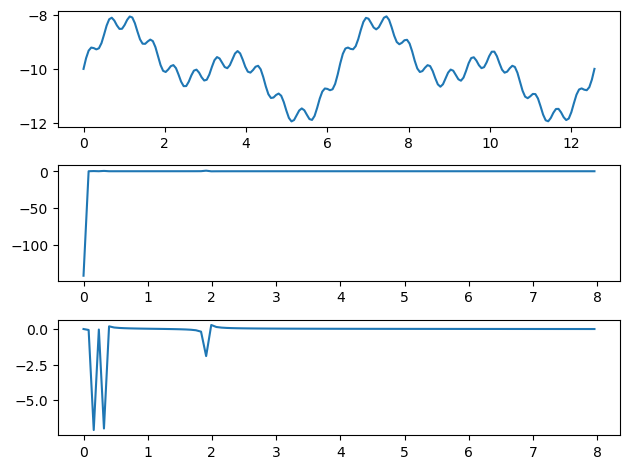

In [14]:
t = torch.linspace(0, 4*torch.pi, 200)
sample_rate = len(t)/(t.max()-t.min())
x = torch.sin(t) + torch.sin(2*t) + 0.3*torch.sin(12*t) - 10
x_freq = torch.fft.rfft(x, norm="ortho")
print(x_freq[0]/torch.sqrt(torch.tensor(200)))
print(x_freq.real[0])
print(x_freq.imag[0])
theta, phi = complex2sphere(x_freq.real, x_freq.imag)

freq = torch.fft.rfftfreq(len(t), 1/sample_rate)
mag = x_freq.abs()
phase = x_freq.angle()
phase[torch.abs(phase) < 1] = 0
fig, axs = plt.subplots(3)
axs[0].plot(t, x)
axs[1].plot(freq, x_freq.real)
axs[2].plot(freq, x_freq.imag)
# axs[1].plot(freq, theta)
# axs[2].plot(freq, phi)
fig.tight_layout()

manuplate on the frequency domain

In [ ]:
N = 20
h = moving_average_freq_response(N, sample_rate=sample_rate, freq=freq)
x_freq_new = x_freq * h
mag = x_freq_new.abs()
phase = x_freq_new.angle()
x_new = torch.fft.irfft(x_freq_new)
x_new_avgpool = torch.nn.functional.avg_pool1d(x.reshape(1,1,-1), N,N).permute(0,2,1)
fig, axs = plt.subplots(3)
# axs[0].plot(x_new)
axs[0].plot(t, x_new)
axs[0].scatter(t[N-1::N], x_new[N-1::N])
axs[0].scatter(t[N-1::N], x_new_avgpool.flatten())
axs[1].plot(freq, mag)
axs[2].plot(freq, phase)

manuplate on the time domain

In [ ]:
from src.utils.filters import MovingAvgTime


x_new = MovingAvgTime(x.reshape(1, -1, 1), N).flatten()
# x_new = np.convolve(np.concatenate([x[-N+1:],x]), np.ones(N)/N, mode='valid')
x_freq = torch.fft.rfft(x_new)
freq = torch.fft.rfftfreq(len(t), 1/sample_rate)
mag = x_freq.abs()
phase = x_freq.angle()

# mag = x_freq_new.abs()
# phase = x_freq_new.angle()
# # print(phase)
# x = torch.fft.irfft(x_freq_new)
print(x_new[N//2:-N//2])
fig, axs = plt.subplots(3)
axs[0].plot(x_new[N//2:-N//2])
# axs[1].plot(freq, mag)
# axs[2].plot(freq, phase)

In [27]:
def crps(y_true, y_pred, sample_weight=None):
    num_samples = y_pred.shape[0]
    absolute_error = np.mean(np.abs(y_pred - y_true), axis=0)

    if num_samples == 1:
        return np.average(absolute_error, weights=sample_weight)

    y_pred = np.sort(y_pred, axis=0)
    b0 = y_pred.mean(axis=0)
    b1_values = y_pred * np.arange(num_samples).reshape(
        -1, *[1 for _ in range(len(y_pred.shape) - 1)]
    )
    b1 = b1_values.mean(axis=0) / num_samples

    per_obs_crps = absolute_error + b0 - 2 * b1
    return np.average(per_obs_crps, weights=sample_weight)

def
a = np.random.rand(50, 32, 100, 2)
b = np.random.rand(32, 100, 2)
crps(b, a)

# print(d * a)
# print(((a+b).view(-1, 2, 3) @ c))
# print(((a+b).view(-1, 2, 3) @ c).reshape(5, 2, 2, 2))
# print(a[...,-1])
# b = a.reshape(-1, 6, 1)
# w = torch.randn()

# ct = ColumnTransformer(
#         [("numbers", StandardScaler(), ["value", "t2m"])], remainder="passthrough"
#     )
# a = pd.DataFrame(a.reshape(3,2).numpy(),columns=["value", "t2m"])
# ct.fit(a)

# ct.named_transformers_['numbers']

(32, 100, 2)
(32, 100, 2)


0.17994859524444387